# Plots for the "Illustrative" Section

In [1]:
using QAOA, Distributions, Interpolations, LinearAlgebra
using HDF5, Printf
using PythonPlot
PythonPlot.matplotlib.style.use("./paper.mplstyle")
PythonPlot.rc("axes", prop_cycle = PythonPlot.matplotlib.cycler(color = ["#2D5FAA", "#B7293F", "#438E6A", "#F7BD2E", "#F16C37"]))

# PATH = "../";
PATH = "/home/ubuntu/Archives/"
PLOT_PATH = "/home/ubuntu/Archives/plots/SK_model/paper/";

In [25]:
using Revise, SpinFluctuations

In [3]:
Base.show(io::IO, f::Float64) = @printf(io, "%1.4f", f)

In [4]:
# N = 9
N = 11

# folder_name = PATH * @sprintf("data/")
subdir = "small_gaps"
# subdir = "large_gaps"
folder_name = PATH * @sprintf("data/SK_model/N_%i/%s/", N, subdir)
instance_names = readdir(folder_name);

In [5]:
# # N = 9
# seed = 131412 
# seed = 23583

# N = 11
seed = 2809;

In [6]:
# # look what's inside
# h5open(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed))

In [7]:
J_mat = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "J")
mf_problem = Problem(0, J_mat);

In [8]:
# T_final = 32000.
T_final = 32768.
npts = 2048
# npts = 4096
coarse_times = range(0, 1, npts + 1);
exact_times = range(0, 1, 33);

## Exact gap

In [9]:
λ = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "exact_ARPACK_LM_eigvals");

In [10]:
gap = λ[2, :] .- λ[1, :];
mingap = minimum(gap)
mingap |> println
gap_idx = findfirst(x -> x == mingap, gap)
gaploc = exact_times[gap_idx]
gaploc |> println

0.0035
0.8125


In [11]:
tol = 1e-8
bogo_spec = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), 
                   @sprintf("bogoliubov_spectrum_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(tol), 32));

In [12]:
all_eigvecs = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "exact_ARPACK_LM_lowest_eigvecs");

In [13]:
H_x = SpinFluctuations.hamiltonian(1, 0, mf_problem.local_fields, mf_problem.couplings)
H_z = SpinFluctuations.hamiltonian(0, 1, mf_problem.local_fields, mf_problem.couplings);

In [14]:
gs = [all_eigvecs[k, :, 1] for k in 1:length(exact_times)]
first_ex = [all_eigvecs[k, :, 2] for k in 1:length(exact_times)]
second_ex = [all_eigvecs[k, :, 3] for k in 1:length(exact_times)]

overlap_01_x = [first_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_01_z = [first_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)]

overlap_02_x = [second_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_02_z = [second_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)];

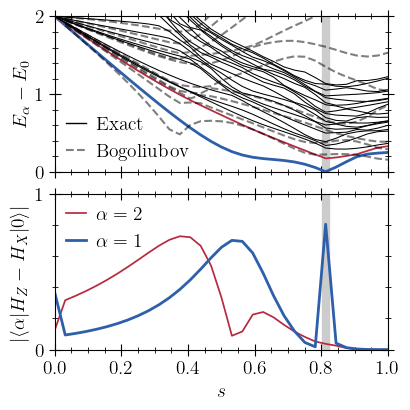

In [15]:
figure(figsize = (4, 4))

ax = subplot(211)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for i in 1:20
	if i == 2 
		plot(exact_times, (λ[i, :] .- λ[1, :]), lw = 2.0, alpha = 1)
	elseif i == 3		
		plot(exact_times, (λ[i, :] .- λ[1, :]), lw = 1.25, alpha = 1)
	else
		plot(exact_times, (λ[i, :] .- λ[1, :]), "-k", lw=0.75, alpha = 1)
	end
	plot(exact_times[2:end], bogo_spec[i, :] , "--k", lw = 1.5, alpha=0.5)
end
plot([], [], "-k", lw = 1, label = "Exact")
plot([], [], label = "Bogoliubov", "--k", lw=1.5, alpha = 0.5)
xlim(0.0, 1.0)
ax.set_yticks(2 .* [0, 0.5, 1.0])
ylim(0, 2)
ax.set_xticklabels([])
ylabel("\$E_\\alpha - E_0\$")
legend(frameon = false, handlelength=1., handletextpad=0.5, borderaxespad=0.2)

ax = subplot(212)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
plot(exact_times, abs.(overlap_02_z .- overlap_02_x), label = "\$\\alpha = 2\$", "-C1", lw=1.25)
plot(exact_times, abs.(overlap_01_z .- overlap_01_x), label = "\$\\alpha = 1\$", "-C0", lw=2.0)
xlim(0.0, 1.0)
ax.set_yticks([0, 1.0])
ylim(0, 1)
xlabel("\$s\$")
ylabel("\${|\\langle \\alpha|H_Z-H_X|0\\rangle|}\$")

legend(ncol=1, handlelength=1., handletextpad=0.5, borderaxespad=0.2, loc="upper left")

tight_layout(pad=0.25)
savefig(PLOT_PATH * @sprintf("exact_spectrum_N_%i_seed_%i.pdf", N, seed), dpi=256, bbox_inches="tight")
display(gcf())
PythonPlot.close();

## Mean-field trajectories

In [16]:
T_final = 32768.
tol = 1e-6
sol_t = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("mean_field_T_final_%.0f_tol_1e%.0f/times", T_final, log10(tol)))
sol_u = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("mean_field_T_final_%.0f_tol_1e%.0f/trajectories", T_final, log10(tol)));

In [17]:
size(sol_u)

(113994, 3, 10)

### Bloch coordinates, Magnetization & Complex Coordinates

In [18]:
nx_vals = n_vals("x", sol_u)
ny_vals = n_vals("y", sol_u)
nz_vals = n_vals("z", sol_u);

In [19]:
nx_coarse = n_coarse(nx_vals, sol_t, coarse_times)
ny_coarse = n_coarse(ny_vals, sol_t, coarse_times)
nz_coarse = n_coarse(nz_vals, sol_t, coarse_times);

In [20]:
S_vals = [transpose(reduce(hcat, [nx_coarse[:, k], ny_coarse[:, k], nz_coarse[:, k]])) |> Matrix for k in 1:npts+1]
magnetizations = reduce(hcat, map(S -> magnetization(S, mf_problem.local_fields, mf_problem.couplings), S_vals));

In [21]:
areas = Dict()
EA_param = Dict()
# dts = [(x[2] - x[1]) / T_final for x in zip(sol_t[1:end-1], sol_t[2:end])]
dts = [(x[2] - x[1]) / T_final for x in zip(coarse_times[1:end-1], coarse_times[2:end])]
for spin_idx in 1:N-1
	# areas[spin_idx] = sum(dts .* nz_vals[spin_idx, 2:end]) |> abs
	areas[spin_idx] = sum(dts .* magnetizations[spin_idx, 2:end]) |> abs

	# Edwards-Anderson
	EA_param[spin_idx] = (1/(N-1)) * sum(dts .* nz_coarse[spin_idx, 2:end] .^ 2) |> abs
end

top_idxs = [k for (k, v) in sort(areas |> collect, by = x -> x[2])]
top_idxs = [k for (k, v) in sort(EA_param |> collect, by = x -> x[2])]
top_idx = top_idxs[1]

6

In [22]:
[(spin_nr, 1e4A) for (spin_nr, A) in sort(EA_param |> collect, by = x -> x[2])]

10-element Vector{Tuple{Int64, Float64}}:
 (6, 0.0037)
 (2, 0.0057)
 (4, 0.0066)
 (1, 0.0067)
 (7, 0.0127)
 (3, 0.0140)
 (8, 0.0143)
 (5, 0.0156)
 (9, 0.0167)
 (10, 0.0170)

In [23]:
[(spin_nr, 1e4A) for (spin_nr, A) in sort(areas |> collect, by = x -> x[2])]

10-element Vector{Tuple{Int64, Float64}}:
 (6, 0.0381)
 (2, 0.0513)
 (1, 0.0638)
 (4, 0.0822)
 (7, 0.0980)
 (3, 0.1767)
 (8, 0.2197)
 (5, 0.2550)
 (9, 0.4693)
 (10, 0.4789)

In [27]:
regular_trajectories = filter!(x -> x != top_idx, collect(1:N-1));
# regular_trajectories = filter!(x -> x != top_idxs[2], regular_trajectories);

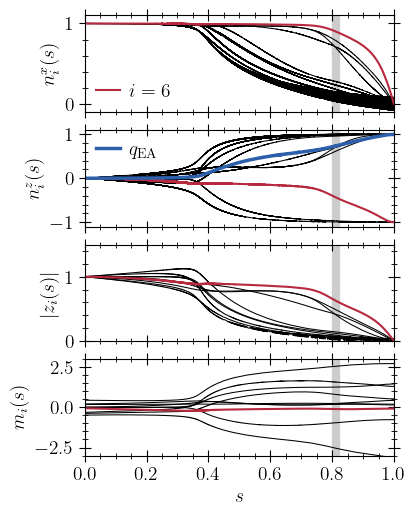

In [143]:
figure(figsize = (4, 5))

c1 = "-C1"
c2 = "-C0"

ax = subplot(411)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in regular_trajectories
	plot(sol_t ./ sol_t[end], nx_vals[spin_nr, :], "-k", lw=0.75)
end
# plot(sol_t ./ sol_t[end], nx_vals[top_idxs[2], :], c2, lw=1, label = @sprintf("\$i=%i\$", top_idxs[2]))
plot(sol_t ./ sol_t[end], nx_vals[top_idx, :], c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))
xlim(0, 1)
ax.set_xticklabels([])
ylim(-0.1, 1.1)
ylabel("\$n_i^x(s)\$")
legend(handlelength=1.2, handletextpad=0.5, borderaxespad=0.2)

ax = subplot(412)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in regular_trajectories
	plot(sol_t ./ T_final, nz_vals[spin_nr, :], "-k", lw=0.75)
end
# plot(sol_t ./ T_final, nz_vals[top_idxs[2], :], c2, lw=1)
plot(sol_t ./ T_final, nz_vals[top_idx, :], c1, lw=1.5)

# Edwards-Anderson
plot(coarse_times, sum([nz_coarse[spin_nr, :] .^ 2 for spin_nr in 1:N-1]) ./ (N-1), "-C0", lw=2.5, label="\$q_{\\mathrm{EA}}\$")
xlim(0, 1)
ylim(-1.1, 1.1)
ax.set_xticklabels([])
ylabel("\$n_i^z(s)\$")
legend(handlelength=1.2, handletextpad=0.5, borderaxespad=0.2)

ax = subplot(413)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in regular_trajectories
	plot(coarse_times, (abs.(complex_coordinate(spin_nr, nx_coarse, ny_coarse, nz_coarse))), "-k", lw=0.75)
end
# plot(coarse_times, (abs.(complex_coordinate(top_idxs[2], nx_coarse, ny_coarse, nz_coarse))), c2, lw=1, label = @sprintf("\$i=%i\$", top_idxs[2]))
plot(coarse_times, (abs.(complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse))), c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))

xlim(0, 1)
ylim(0, 1.5)
ax.set_xticklabels([])
ylabel("\$|z_i(s)|\$")

ax = subplot(414)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in regular_trajectories
	plot(coarse_times, magnetizations[spin_nr, :], "-k", lw=0.75)
end
# plot(coarse_times, magnetizations[top_idxs[2], :], c2, lw=1, label = @sprintf("\$i=%i\$", top_idxs[2]))
plot(coarse_times, magnetizations[top_idx, :], c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))

xlim(0.0, 1)
ylim(-3, 3)
xlabel("\$s\$")
ylabel("\$m_i(s)\$")

tight_layout(pad=0.1)
display(gcf())
savefig(PLOT_PATH * @sprintf("mean_fields_N_%i_seed_%i.pdf", N, seed), dpi=256, bbox_inches="tight")
PythonPlot.close();

## Energies

In [32]:
sigma_star = sign.(sol_u[end, 3, :])
h = mf_problem.local_fields
J = mf_problem.couplings
E = sum([-h[l] * sigma_star[l] for l in 1:N-1]) + sum([-J[i, j] * sigma_star[i] * sigma_star[j] for i in 1:N-1 for j in (i+1):N-1])

-5.6975

In [33]:
[λ[k, :][end] for k in 1:6] |> println

[-6.0652, -5.8137, -5.7335, -5.6975, -5.5399, -5.5178]


In [630]:
isapprox.([λ[k, :][end] for k in 1:6], E, atol=1e-5) |> println

Bool[0, 0, 0, 1, 0, 0]


In [631]:
# for spin_idx in 1:N-1
# 	sigma_star_flip = sign.(sol_u[end, 3, :])
# 	sigma_star_flip[spin_idx] = (-1) * sigma_star_flip[spin_idx]
# 	E_flip = sum([-h[l] * sigma_star_flip[l] for l in 1:N-1]) + sum([-J[i, j] * sigma_star_flip[i] * sigma_star_flip[j] for i in 1:N-1 for j in (i+1):N-1])
# 	println(spin_idx, ": ", E_flip)
# end

## Statistical Green function

In [34]:
tol = 1e-8
all_flucs = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("fluctuations_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(1e-8), npts));

In [36]:
regular_trajectories = filter!(x -> x != top_idxs[1], collect(1:N-1));
# regular_trajectories = filter!(x -> x != top_idxs[2], regular_trajectories);

scale_factors = [1 .+ abs.(complex_coordinate(i, nx_coarse, ny_coarse, nz_coarse)) .^ 2 for i in 1:N-1]
mean_flucs = mean([smoothen(all_flucs[i, :], coarse_times) for i in regular_trajectories], dims=1)[1];
mean_scaled_flucs = mean([smoothen(scale_factors[i] .^ 2 .* all_flucs[i, :], coarse_times) for i in regular_trajectories], dims = 1)[1];

In [42]:
inv_mag = 1 ./ (magnetizations[top_idx, :] .|> abs)
local_EA_param = nz_coarse[top_idx, :].^2
# local_EA_param = sum([nz_coarse[i, :].^2 for i in 1:N-1])
# local_EA_param = sum([smoothen(1 ./ nz_coarse[i, :].^2, coarse_times) for i in 1:N-1])
scale_factor = 1 .+ abs.(complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse)) .^ 2

top_flucs = smoothen(scale_factor.^2 .* all_flucs[top_idx, :], coarse_times, navg=256);# .* inv_mag;
crit_flucs = scale_factor.^2 .* all_flucs[top_idx, :] .* local_EA_param;
crit_flucs = smoothen(scale_factor.^2 .* all_flucs[top_idx, :] .* local_EA_param, coarse_times, navg=64);
# crit_flucs = smoothen(scale_factor.^2 .* all_flucs[top_idx, :] ./ local_EA_param, coarse_times, navg=64);

In [43]:
maximum(abs.(overlap_01_z .- overlap_01_x) ./ ((λ[2, :] .- λ[1, :]).^2))

64769.3733

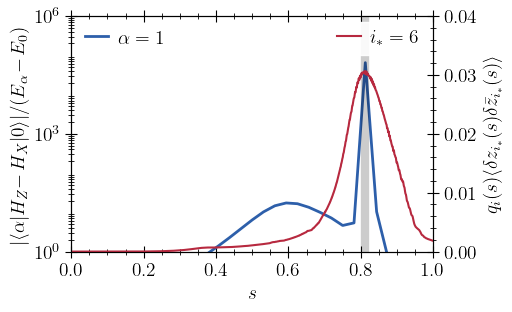

In [191]:
figure(figsize = (5., 5.4))
ax = subplot(211)
twinax = ax.twinx()
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
ax.semilogy(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ ((λ[2, :] .- λ[1, :]).^2), label = "\$\\alpha = 1\$", lw=2)
# ax.semilogy(exact_times, abs.(overlap_02_z .- overlap_02_x) ./ ((λ[3, :] .- λ[1, :]).^2), label="\$\\alpha = 2\$", lw=1.25)
twinax.plot(coarse_times, crit_flucs, c1, lw=1.5, label=@sprintf("\$i_*=%s\$", top_idx))
xlim(0.0, 1.0)
ax.set_ylim(1e0, 1e6)
ax.set_yticks([1e0, 1e3, 1e6])
twinax.set_ylim(0, 0.04)
ax.set_xlabel("\$s\$")
# ylabel("\$\\frac{|\\langle \\alpha|H_Z-H_X|0\\rangle|}{E_\\alpha - E_0}\$")
ax.set_ylabel("\$|\\langle \\alpha|H_Z \\hspace{-1mm} - \\hspace{-0.5mm} H_X|0\\rangle|/(E_\\alpha \\hspace{-1mm} - \\hspace{-0.5mm} E_0)\$")
twinax.set_ylabel("\$ q_i(s)\\langle\\delta  z_{i_*}(s) \\delta \\bar z_{i_*}(s) \\rangle\$")
ax.legend(loc="upper left", handlelength=1.2, handletextpad=0.5, borderaxespad=0.3)
twinax.legend(loc="upper right", frameon=true, framealpha=0.9, edgecolor="w", 
              handlelength=1.2, handletextpad=0.5, borderaxespad=0.3)

tight_layout(pad=0.2)
savefig(PLOT_PATH * @sprintf("metric_N_%i_seed_%i.pdf", N, seed), dpi=256, bbox_inches="tight")
display(gcf())
PythonPlot.close();

## Fluctuations & Spectrum

In [125]:
T_final = 32768.
τ_final = 2048.0

npts_diag = 16
T_diags = T_final .* range(0.5, 1.0, npts_diag + 1)

ωs = []
spec_sum = []
for k in 1:17
	push!(ωs, 2pi .* h5read(folder_name * "results_" * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("spectra_T_final_%i_tau_final_%i/T_%0.5f/omegas", T_final, τ_final, T_diags[k] / T_final)))
	push!(spec_sum, h5read(folder_name * "results_" * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("spectra_T_final_%i_tau_final_%i/T_%0.5f/data", T_final, τ_final, T_diags[k] / T_final)))
end

In [140]:
t_idx = 11
t_idx_2 = 1
println(gaploc)
println(T_diags[t_idx] ./ T_final)
println(T_diags[t_idx_2] ./ T_final)

0.8125
0.8125
0.5000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


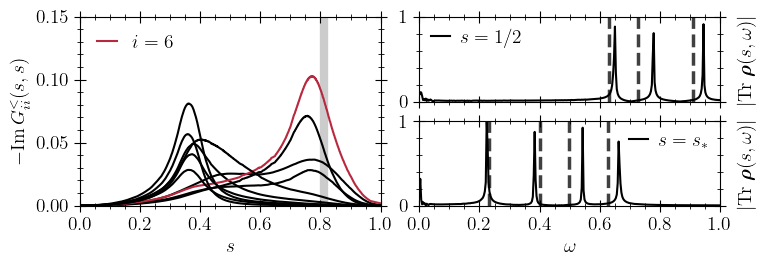

In [151]:
figure(figsize = (7.5, 2.5))

ax = subplot(121)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
all_colors = ["-k" for _ in 1:N-1]
all_colors[top_idx] = c1
# all_colors[top_idxs[2]] = c2
all_labels = ["" for _ in 1:N-1]
all_labels[top_idx] = @sprintf("\$i=%s\$", string(top_idx))
# all_labels[top_idxs[2]] = @sprintf("\$i=%s\$", string(top_idxs[2]))
for i in 1:(N-1)
	scale_factor = 1 # .+ abs.(complex_coordinate(i, nx_coarse, ny_coarse, nz_coarse)) .^ 2
	plot(coarse_times, scale_factor .^ 2 .* smoothen(all_flucs[i, :], coarse_times, navg=128), label=all_labels[i], all_colors[i])
	xlim(0.0, 1.0)
	legend(frameon = false, handlelength = 1, ncol=1)
end
xlabel("\$s\$")
ax.set_ylabel("\$ -\\mathrm{Im}\\, G^<_{ii}(s, s) \$")
# ax.set_ylabel("\$ \\langle\\delta \\bar z_i(s) \\delta z_i(s) \\rangle\$")
xlim(0, 1)
ylim(0, 0.15)

ax = subplot(222)
cs = ["k"]
axvline.(bogo_spec[N:end, 16+t_idx_2], c=cs[1], alpha = 0.75, ls = "--", lw=2.5)
labelstrs = ["\$s = 1/2\$"]
for (i, k) in enumerate([t_idx_2])
	plot(ωs[t_idx_2], spec_sum[t_idx_2], c=cs[i], label=labelstrs[i])#, label=@sprintf("\$T/T_f = %.2f\$", T_diags[k] ./ T_final))
end
xlim(0., 1.)
ylim(-0.0, 1)
ax.set_xticklabels([])
ax.set_yticks([0, 1.0])
# ylabel("\$\\left|\\mathrm{Tr}\\;\\boldsymbol{\\rho}(T, \\omega)\\right|\$", labelpad=8)
ylabel("\$\\left|\\mathrm{Tr}\\;\\boldsymbol{\\rho}(s, \\omega)\\right|\$", labelpad=8)
# legend(loc="upper left", handlelength=1.0, frameon=true, framealpha=0.9, edgecolor="w")
legend(handlelength=1., handletextpad=0.5, borderaxespad=0.2)
ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()

ax = subplot(224)
cs = ["k"]
axvline.(bogo_spec[N:end, 16+t_idx], c=cs[1], alpha = 0.75, ls = "--", lw=2.5)
labelstrs = ["\$s = s_*\$"]
for (i, k) in enumerate([t_idx])
	plot(ωs[t_idx], spec_sum[t_idx], c=cs[i], label=labelstrs[i])#, label=@sprintf("\$T/T_f = %.2f\$", T_diags[k] ./ T_final))
end
xlim(0., 1.)
ylim(-0.0, 1)
yticks([0, 1.0])
xlabel("\$\\omega\$")
ylabel("\$\\left|\\mathrm{Tr}\\;\\boldsymbol{\\rho}(s, \\omega)\\right|\$", labelpad=8)
# legend(loc="upper right", handlelength=0.9, frameon=false, framealpha=0.9, edgecolor="w")
legend(handlelength=1., handletextpad=0.5, borderaxespad=0.2)
ax.yaxis.set_label_position("right")


tight_layout(pad=0.1)
savefig(PLOT_PATH * @sprintf("statistical_and_spectral_N_%i_seed_%i.pdf", N, seed), dpi=256, bbox_inches="tight")
display(gcf())
PythonPlot.close();

## More Details

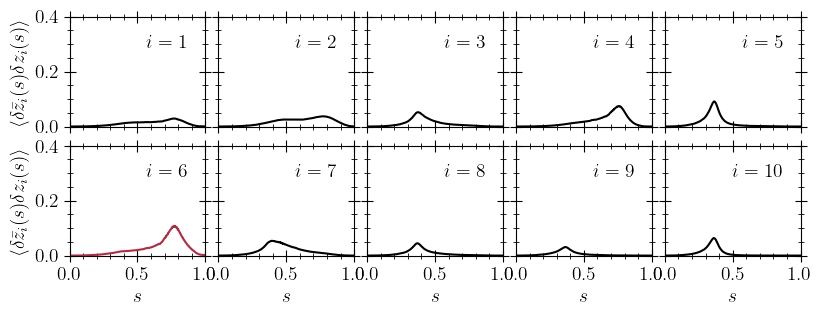

In [192]:
figure(figsize = (8, 3))
ylims = (0, 0.4)

for i in 1:(N-1)÷2
	ax = subplot(2, (N - 1) ÷ 2, i)
	c = "k"
	if i in [top_idx]
		c = "C1"
	end
	scale_factor = 1 #.+ abs.(complex_coordinate(i, nx_coarse, ny_coarse, nz_coarse)) .^ 2
	plot(coarse_times, scale_factor .^ 2 .* smoothen(all_flucs[i, :], coarse_times), label = @sprintf("\$i=%s\$", string(i)), c = c)
	xlim(0.0, 1.0)
	ax.set_xticklabels([])
	ylim(ylims...)
	if i > 1
		ax.set_yticklabels([])
	end
	legend(frameon = false, handlelength = 0)
end

ax = subplot(2, (N - 1) ÷ 2, 1)
ax.set_ylabel("\$ \\langle\\delta \\bar z_i(s) \\delta z_i(s) \\rangle\$")

for i in (N-1)÷2+1:N-1
	ax = subplot(2, (N - 1) ÷ 2, i)
	c = "k"
	if i in [top_idx]
		c = "C1"
	end
	scale_factor = 1 #.+ abs.(complex_coordinate(i, nx_coarse, ny_coarse, nz_coarse)) .^ 2
	plot(coarse_times, scale_factor .^ 2 .* smoothen(all_flucs[i, :], coarse_times), label = @sprintf("\$i=%s\$", string(i)), c = c)
	xlim(0.0, 1.0)
	ylim(ylims...)
	if i > (N - 1) ÷ 2 + 1
		ax.set_yticklabels([])
	end
	xlabel("\$s\$")
	legend(frameon = false, handlelength = 0)
end

ax = subplot(2, (N - 1) ÷ 2, (N - 1) ÷ 2 + 1)
ax.set_ylabel("\$ \\langle\\delta \\bar z_i(s) \\delta z_i(s) \\rangle\$")

tight_layout(pad=0.1)
display(gcf())
PythonPlot.close();

In [194]:
tol = 1e-8
T_final = 32768.0
npts = 2048
coarse_times_fine = range(0, 1, npts + 1);
all_flucs_fine = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("fluctuations_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(1e-8), npts));

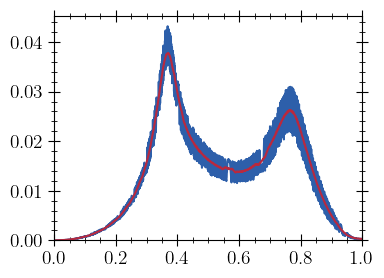

In [195]:
figure(figsize = (4, 3))
plot(coarse_times_fine, mean(all_flucs_fine, dims = 1)[1, :])
plot(coarse_times, smoothen(mean(all_flucs, dims = 1)[1, :], coarse_times), "-")
tight_layout()
xlim(0, 1)
ylim(0)
display(gcf())
tight_layout()
PythonPlot.close();
